In [1]:
from config import cfg
import os
import numpy as np
import pandas as pd
import mne
from util import read_emg, read_manus
from scipy.signal import butter, filtfilt, iirnotch, sosfiltfilt, stft


In [2]:
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler

class ExpTimes:
    refernce_time = datetime.strptime('2023-10-02 14:59:55.627000', '%Y-%m-%d %H:%M:%S.%f')
    manus_start_time = datetime.strptime('2023-10-02 14:59:20.799000', '%Y-%m-%d %H:%M:%S.%f')
    emg_start_time = datetime.strptime('2023-10-02 14:59:55.627000', '%Y-%m-%d %H:%M:%S.%f')
    video_Start_time = datetime.strptime('2023-10-02 14:59:55.628000', '%Y-%m-%d %H:%M:%S.%f')

    manus_columns = ['Pinch_ThumbToIndex','Pinch_ThumbToMiddle', 'Pinch_ThumbToRing',
                     'Pinch_ThumbToPinky', 'Thumb_CMC_Spread', 'Thumb_CMC_Flex', 'Thumb_PIP_Flex', 'Thumb_DIP_Flex',
                     'Index_MCP_Spread', 'Index_MCP_Flex', 'Index_PIP_Flex', 'Index_DIP_Flex', 'Middle_MCP_Spread',
                     'Middle_MCP_Flex', 'Middle_PIP_Flex', 'Middle_DIP_Flex', 'Ring_MCP_Spread', 'Ring_MCP_Flex',
                     'Ring_PIP_Flex', 'Ring_DIP_Flex', 'Pinky_MCP_Spread', 'Pinky_MCP_Flex', 'Pinky_PIP_Flex',
                     'Pinky_DIP_Flex','time']


In [3]:
# edf_path = os.path.join(cfg.DATA.PATH, 'test 2023-10-02 14-59-55-627.edf')
# manus_path = os.path.join(cfg.DATA.PATH, 'Untitled_2023-10-02_15-24-12_YH_lab_R.csv')

# #read data
# df = read_data([manus_path, edf_path])
# df.head()

In [33]:
# make a tesor dataset class
from torch.utils.data import Dataset
import torch
DATA_SOURCES = {
    'manus': read_manus,
    'emg': read_emg,
}
class EMGDataset(Dataset):
    def __init__(self, data_path, label_path, transform=None, data_source='emg', label_source='manus'):

        self.data_path = data_path
        self.label_path = label_path

        self.transform = transform

        self.data_source = data_source # emg or imu
        self.label_source = label_source   # manus, video, or ultraleap 

        self.emg_columns = ['channel {}'.format(i) for i in range(16)]
        self.mauns_columns = ['Pinch_ThumbToIndex','Pinch_ThumbToMiddle', 'Pinch_ThumbToRing',
                        'Pinch_ThumbToPinky', 'Thumb_CMC_Spread', 'Thumb_CMC_Flex', 'Thumb_PIP_Flex', 'Thumb_DIP_Flex',
                        'Index_MCP_Spread', 'Index_MCP_Flex', 'Index_PIP_Flex', 'Index_DIP_Flex', 'Middle_MCP_Spread',
                        'Middle_MCP_Flex', 'Middle_PIP_Flex', 'Middle_DIP_Flex', 'Ring_MCP_Spread', 'Ring_MCP_Flex',
                        'Ring_PIP_Flex', 'Ring_DIP_Flex', 'Pinky_MCP_Spread', 'Pinky_MCP_Flex', 'Pinky_PIP_Flex',
                        'Pinky_DIP_Flex','time']
        
        self.prepare_data()

        print(f'shape of data: {self.data.shape}\nshape of label: {self.label.shape}')
        
    def prepare_data(self):
        data =  DATA_SOURCES[self.data_source](self.data_path)
        label = DATA_SOURCES[self.label_source](self.label_path)
        
        # set the start and end of experiment
        start_time = max(min(data.index), min(label.index))
        end_time = min(max(data.index), max(label.index))

        # select only the data between start and end time
        data = data.loc[start_time:end_time]
        label = label.loc[start_time:end_time]

        # # make sure the dataframes are of the same length for the merge
        # df = pd.merge_asof(data, label, on='time', direction='nearest')
        # print(df.describe())
        # assert df.shape[0] == data.shape[0] & df.shape[0] == label.shape[0], 'Dataframes are not of the same length'
        # del df

        #reset index to numeric values
        data.reset_index(drop=True, inplace=True)
        label.reset_index(drop=True, inplace=True)

        #convert to numpy array
        self.data = data.to_numpy()
        self.label = label.to_numpy()

        # normalize the data
        scaler = MinMaxScaler()
        self.data = scaler.fit_transform(self.data)
        print(np.mean(self.data, axis=0))

        #filter data
        self.data = self._filter_data(self.data, fs=cfg.DATA.EMG.SAMPLING_RATE, 
                                      notch=cfg.DATA.EMG.NOTCH, low_freq=cfg.DATA.EMG.LOW_FREQ, 
                                      high_freq=cfg.DATA.EMG.HIGH_FREQ, buff_len=cfg.DATA.EMG.BUFF_LEN)


        #discritize
        self.data = self.unfold(self.data, cfg.DATA.SEGMENT_LENGTH)
        self.label = self.unfold(self.label, cfg.DATA.SEGMENT_LENGTH)

        # convert to tensor
        self.data = torch.tensor(data.values)
        self.label = torch.tensor(label.values)


    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.label[idx]
        return data, label
    # read emg signal
    
    @staticmethod
    def _filter_data(data: np.ndarray, fs: float, notch: float=50, low_freq: float=30.0, high_freq: float=250.0,
                     buff_len: int = 0) -> np.ndarray:
        # Define the notch frequency and quality factor
        notch_freq = 50  # Hz
        Q = 30

        # Calculate the normalized frequency and design the filter
        w0 = notch_freq / (fs / 2)
        b_notch, a_notch = iirnotch(w0, Q)

        cutoff = low_freq / (fs / 2)
        sos = butter(5, cutoff, btype='highpass', output='sos')

        # apply filters using 'filtfilt' to avoid phase shift
        data = sosfiltfilt(sos, data, axis=0, padtype='even')

        # Apply the filter to your signal using filtfilt to avoid phase shift
        filtered_signal = filtfilt(b_notch, a_notch, data, axis=0)
        
        return filtered_signal
    
    @staticmethod
    def unfold(data, seq_len):
        '''
        Unfold the data into segments of length seq_len
        Input: data: numpy array of shape (num_samples, num_features)
                seq_len: length of each segment
        Output: segments: numpy array of shape (num_segments, seq_len, num_features)
        '''
        original_length, num_features = data.shape
        num_segments = (original_length - seq_len + 1) * seq_len

        # Reshape the data to (num_segments, seq_len, num_features)
        segments = np.lib.stride_tricks.sliding_window_view(data, (seq_len, num_features))
        segments = segments.squeeze(1)
        return segments
    
    @staticmethod
    def fold(data):
        '''
        Fold the data into a single array
        Input: segments: numpy array of shape (num_segments, seq_len, num_features)
        Output: segments: numpy array of shape (num_samples, num_features)
        '''
        num_segments, seq_len, num_features = data.shape
        original_length = int(num_segments) + seq_len - 1

        # Reshape the data to (num_segments, seq_len, num_features)
        segments = np.lib.stride_tricks.as_strided(data, shape=(original_length, num_features), strides=(1,1))
        return segments

        

In [34]:
cfg.DATA.PATH = './dataset'
manus_path = os.path.join(cfg.DATA.PATH, 'label_2023-10-02_15-24-12_YH_lab_R.csv')
edf_path = os.path.join(cfg.DATA.PATH, 'data_2023-10-02 14-59-55-627.edf')
dataset = EMGDataset(edf_path, manus_path)

Extracting EDF parameters from /Users/rufaelmarew/Documents/tau/finger_pose_estimation/dataset/data_2023-10-02 14-59-55-627.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 345249  =      0.000 ...  1380.996 secs...
[0.25865115 0.33326892 0.30698319 0.68790302 0.58707595 0.29151348
 0.6215265  0.55734055 0.58024484 0.24583599 0.40195859 0.49674369
 0.71937961 0.30416957 0.62774826 0.24275556]
shape of data: (164650, 16)
shape of label: (164650, 15)


In [35]:
print(dataset.data.shape)

(164650, 16)


In [36]:
# dataset.fold(dataset.data).shape

In [37]:
np.min(dataset.data[:,0])

-0.24426493778908734

(164650, 16)


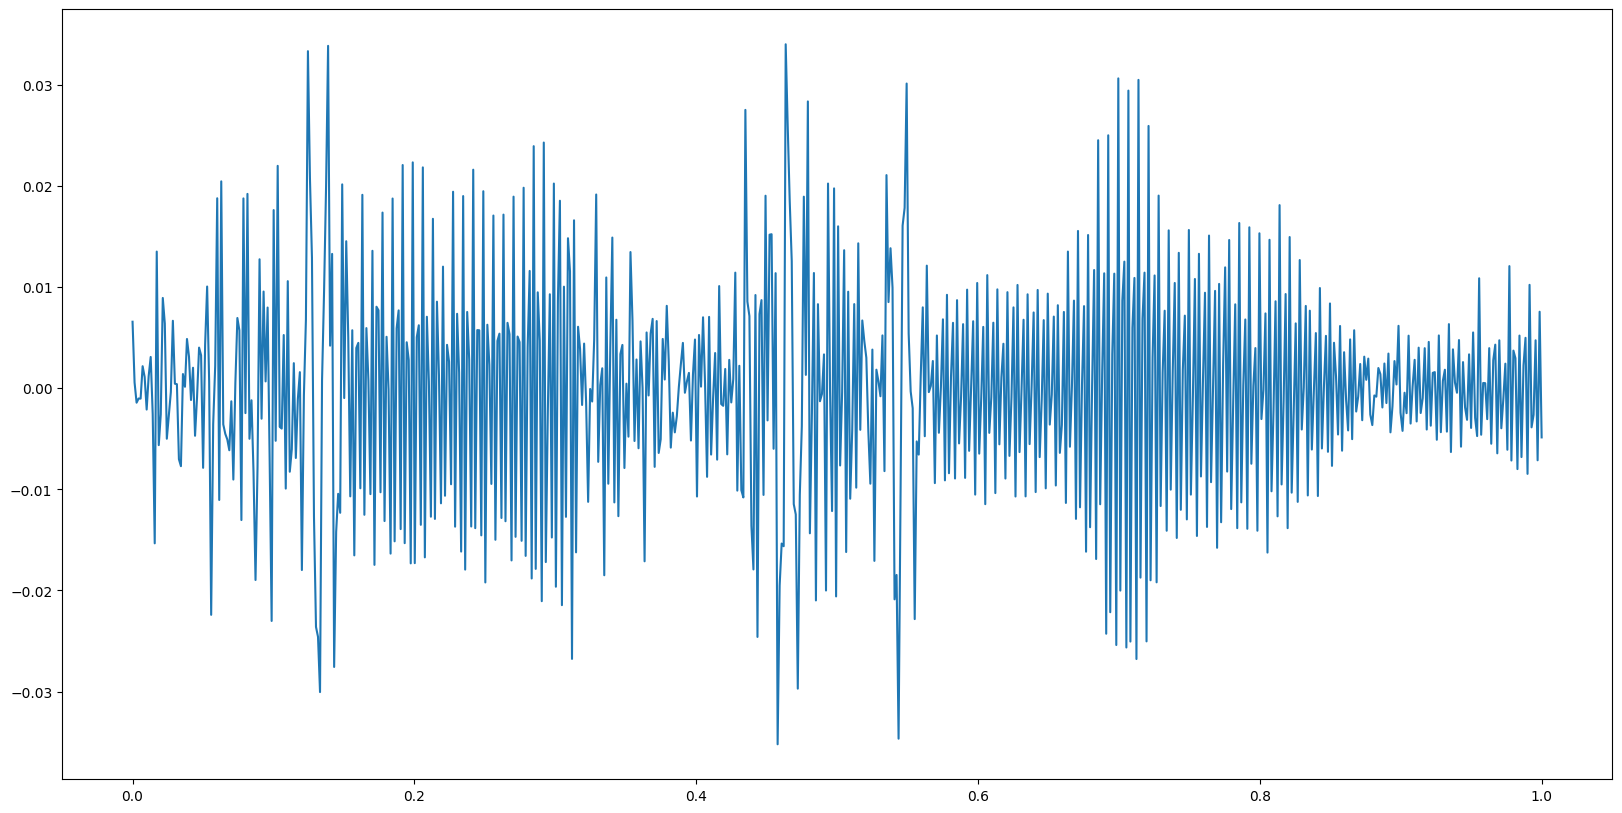

In [38]:
def plot_data(to_plot):
    import matplotlib.pyplot as plt
    # fold the data
    print(to_plot.shape)
    t = np.linspace(0, 1, to_plot[:700,:].shape[0])
    # set figure size
    plt.figure(figsize=(20,10))
    plt.plot(t, to_plot[:700,0])
    plt.show()
plot_data(dataset.data)